In [1]:
import os
import numpy as np
import pandas as pd
import sys


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
# sns.set_style("whitegrid")
sns.set_theme()

In [2]:
RESULTS_DIR = "./outputs/experiment1-no-scale-uncertainty-loss"
!ls {RESULTS_DIR}

baseline


This notebook concerns the evaluation of the model's results.

In [3]:
def color(data, cmap="Blues"):
    return data.style.background_gradient(cmap=cmap, low=0, high=1.0, axis=0)

## Global segmentation results

In [4]:
for model_dir in os.listdir(RESULTS_DIR):
    print(model_dir)
    gs_results = pd.read_csv(f"{RESULTS_DIR}/{model_dir}/segmentation_global.csv")
    print(gs_results[~gs_results.name.str.contains("polygon")])

    pc_results= pd.read_csv(f"{RESULTS_DIR}/{model_dir}/segmentation_by_class.csv")
    print(pc_results[(pc_results.name == "Room segmentation") & (pc_results.class_names == "Wall")])

    hm_results = pd.read_csv(f"{RESULTS_DIR}/{model_dir}/segmentation_heatmaps.csv")
    print(hm_results)
    print()

baseline
                name  Overall Acc  Mean Acc  FreqW Acc  Mean IoU
0  Room segmentation     0.825466  0.695622   0.716839  0.572838
2  Icon segmentation     0.975056  0.602284   0.953138  0.549513
                name class_names  Class IoU  Class Acc
2  Room segmentation        Wall      72.16      83.29
                  name  Mean IoU
0  Junction Prediction   0.00123



### Class segmentation results

In [5]:
# RESULTS_DIR = RESULTS_DIR + '/baseline'
RESULTS_DIR = './outputs/baseline'

In [6]:
class_seg_results = pd.read_csv(f"{RESULTS_DIR}/segmentation_by_class.csv")
room_mask = class_seg_results.name.isin(["Room segmentation", "Room polygon segmentation"])
room_seg_results, icon_seg_results = class_seg_results[room_mask], class_seg_results[~room_mask]

In [7]:
def get_all_metrics(data):
    ious = data.copy()    
    ious.rename(columns={"Class IoU": "value"}, inplace=True)
    ious.drop(columns=["Class Acc"], inplace=True)
    ious["metric"] = "Class IoU"

    accs = data.copy()    
    accs.rename(columns={"Class Acc": "value"}, inplace=True)
    accs.drop(columns=["Class IoU"], inplace=True)
    accs["metric"] = "Class Acc"

    concat = pd.concat([ious, accs])
    return concat

<AxesSubplot:title={'center':'Room segmentation results discriminated by class'}, xlabel='value', ylabel='class_names'>

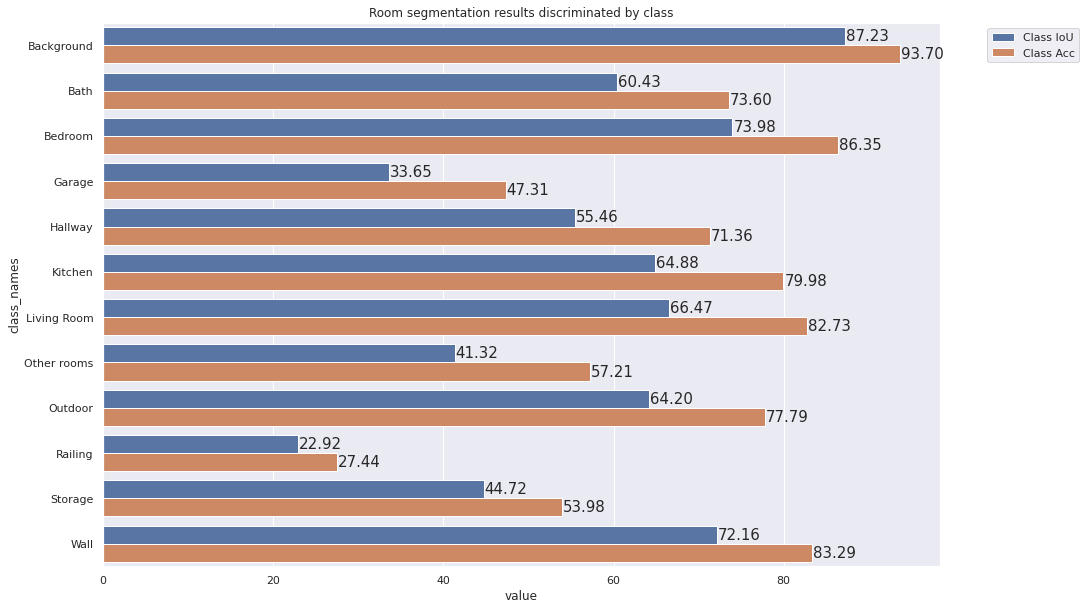

In [8]:
def plot_segmentation_results(data, figsize=(15, 10)):
    data = data.sort_values("class_names")
    plt.figure(figsize=figsize)
    plt.title(f"Room segmentation results discriminated by class")
    plt.ylabel("Class names")
    
    hue_order = ['Class IoU', 'Class Acc']
    splot = sns.barplot(data=data, x="value", y="class_names", hue="metric", hue_order=hue_order, orient="h")

    for p in splot.patches:

        splot.annotate(
            format(p.get_width(), '.2f'), 
            xy=(p.get_width(), p.get_y()+p.get_height()/2),
            ha = 'left',
            va = 'center', 
            size=15, 
            xytext = (1, 0),
            textcoords = 'offset points')
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    return splot
        

all_room = get_all_metrics(room_seg_results)
plot_segmentation_results(data=all_room[all_room.name=='Room segmentation'])

### Icon segmentation results

<AxesSubplot:title={'center':'Room segmentation results discriminated by class'}, xlabel='value', ylabel='class_names'>

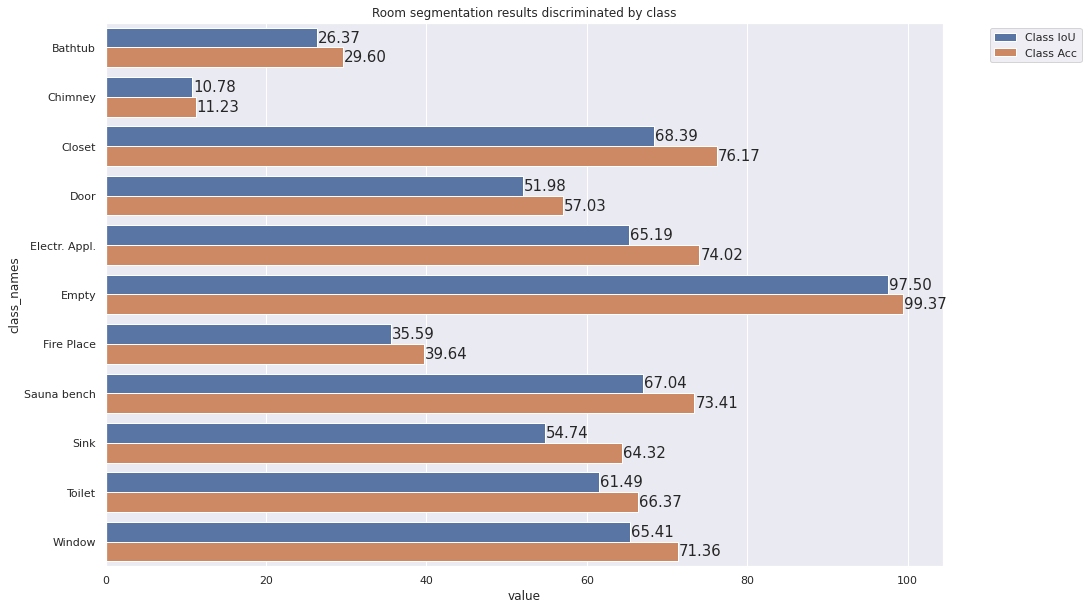

In [9]:
all_icon = get_all_metrics(icon_seg_results)
plot_segmentation_results(data=all_icon[all_icon.name == 'Icon segmentation'])

## Junctions per class

In [62]:
def plot_per_class(
    data: pd.DataFrame,
    by: str,
    x: str,
    y: str,
    n_cols: int=3,
    figsize=(15, 15),
    dpi=150,
    **kwargs
):
    n_plots = data[by].nunique()

    n_rows = n_plots // n_cols
    n_rows += n_plots % n_cols

    position = range(1, n_plots+1)

    fig = plt.figure(1, figsize=figsize, dpi=dpi)

    for k, by_category in enumerate(data[by].unique()):
        d = data[(data[by] == by_category)].copy()
        d["F1-score"] = (2*(d["Precision"]/100)*(d["Recall"]/100))/(d["Precision"]/100+d["Recall"]/100)
        d.reset_index(inplace=True, drop=True)

        ax = fig.add_subplot(n_rows, n_cols, position[k])
        sns.lineplot(data=d, x=x, y=y, ax=ax, markers=True, style='class', legend=None, **kwargs)
        # ax.set_title(f"({by}={by_category}) {y}-{x} curve")
        ax.set_title(f"{by}={by_category}")
        ax.set_xlabel("Recall (%)")
        ax.set_ylabel("Precision (%)")
        ax.set_ylim((15, 105))
        ax.set_xlim((-5, 105))

        for index, row in d.iterrows():
            ax.text(row["Recall"], row["Precision"], f"{row['F1-score']:.3f}")

    plt.tight_layout()
    plt.savefig(RESULTS_DIR + '/per-class-evaluation-all-classes.eps')

In [11]:
junctions = pd.read_csv(f"{RESULTS_DIR}/wall_junctions_per_class.csv")
overall_mask = junctions["class"] == "overall"

junctions_overall = junctions[overall_mask]
junctions_by_class = junctions[~overall_mask]

In [12]:
# junctions_overall.loc[100, 'Precision'] = 100.00

junctions_overall["F1-score"] = (2*(junctions_overall["Precision"]/100)*(junctions_overall["Recall"]/100))/(junctions_overall["Precision"]/100+junctions_overall["Recall"]/100)
junctions_overall.reset_index(inplace=True, drop=True)
junctions_overall

/tmp/ipykernel_1186/2864121632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junctions_overall["F1-score"] = (2*(junctions_overall["Precision"]/100)*(junctions_overall["Recall"]/100))/(junctions_overall["Precision"]/100+junctions_overall["Recall"]/100)


,threshold,class,Recall,Precision,F1-score
0,0,overall,77.86,32.79,0.461460
1,10,overall,72.00,47.87,0.575063
2,20,overall,63.99,65.45,0.647118
3,30,overall,55.30,76.10,0.640537
4,40,overall,45.61,82.84,0.588296
5,50,overall,34.07,87.41,0.490296
6,60,overall,22.12,92.86,0.357291
7,70,overall,11.78,95.07,0.209626
8,80,overall,3.64,95.72,0.070133
9,90,overall,0.14,100.00,0.002796


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


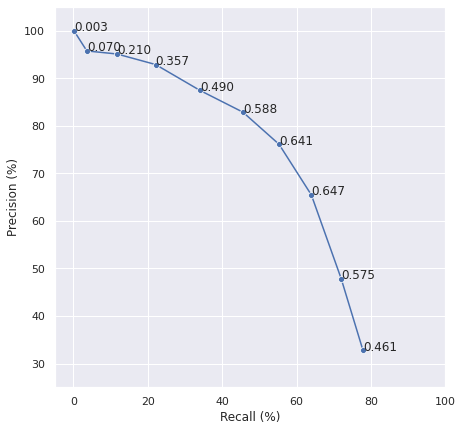

In [13]:
plt.figure(figsize=(7,7))
g = sns.lineplot(data=junctions_overall, x="Recall", y="Precision", markers=True, style="class", legend=None)
plt.ylabel("Precision (%)")
plt.xlabel("Recall (%)")
# sns.lineplot(data=junctions_overall, x="Threshold", y="Precision", markers=True, style="class", ax=g.axes.twiny(), legend=None)
# plt.title("Precision-Recall curve for Junctions *overall*")

for index, row in junctions_overall.iterrows():
    # plt.text(row["Recall"], row["Precision"], f"t={row['threshold]}; {row['F1-score']:.3f}")
    plt.text(row["Recall"], row["Precision"], f"{row['F1-score']:.3f}")

plt.xlim(-5, 100)
plt.ylim(25, 105)
plt.savefig(RESULTS_DIR + '/precision-recall-overall.eps')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

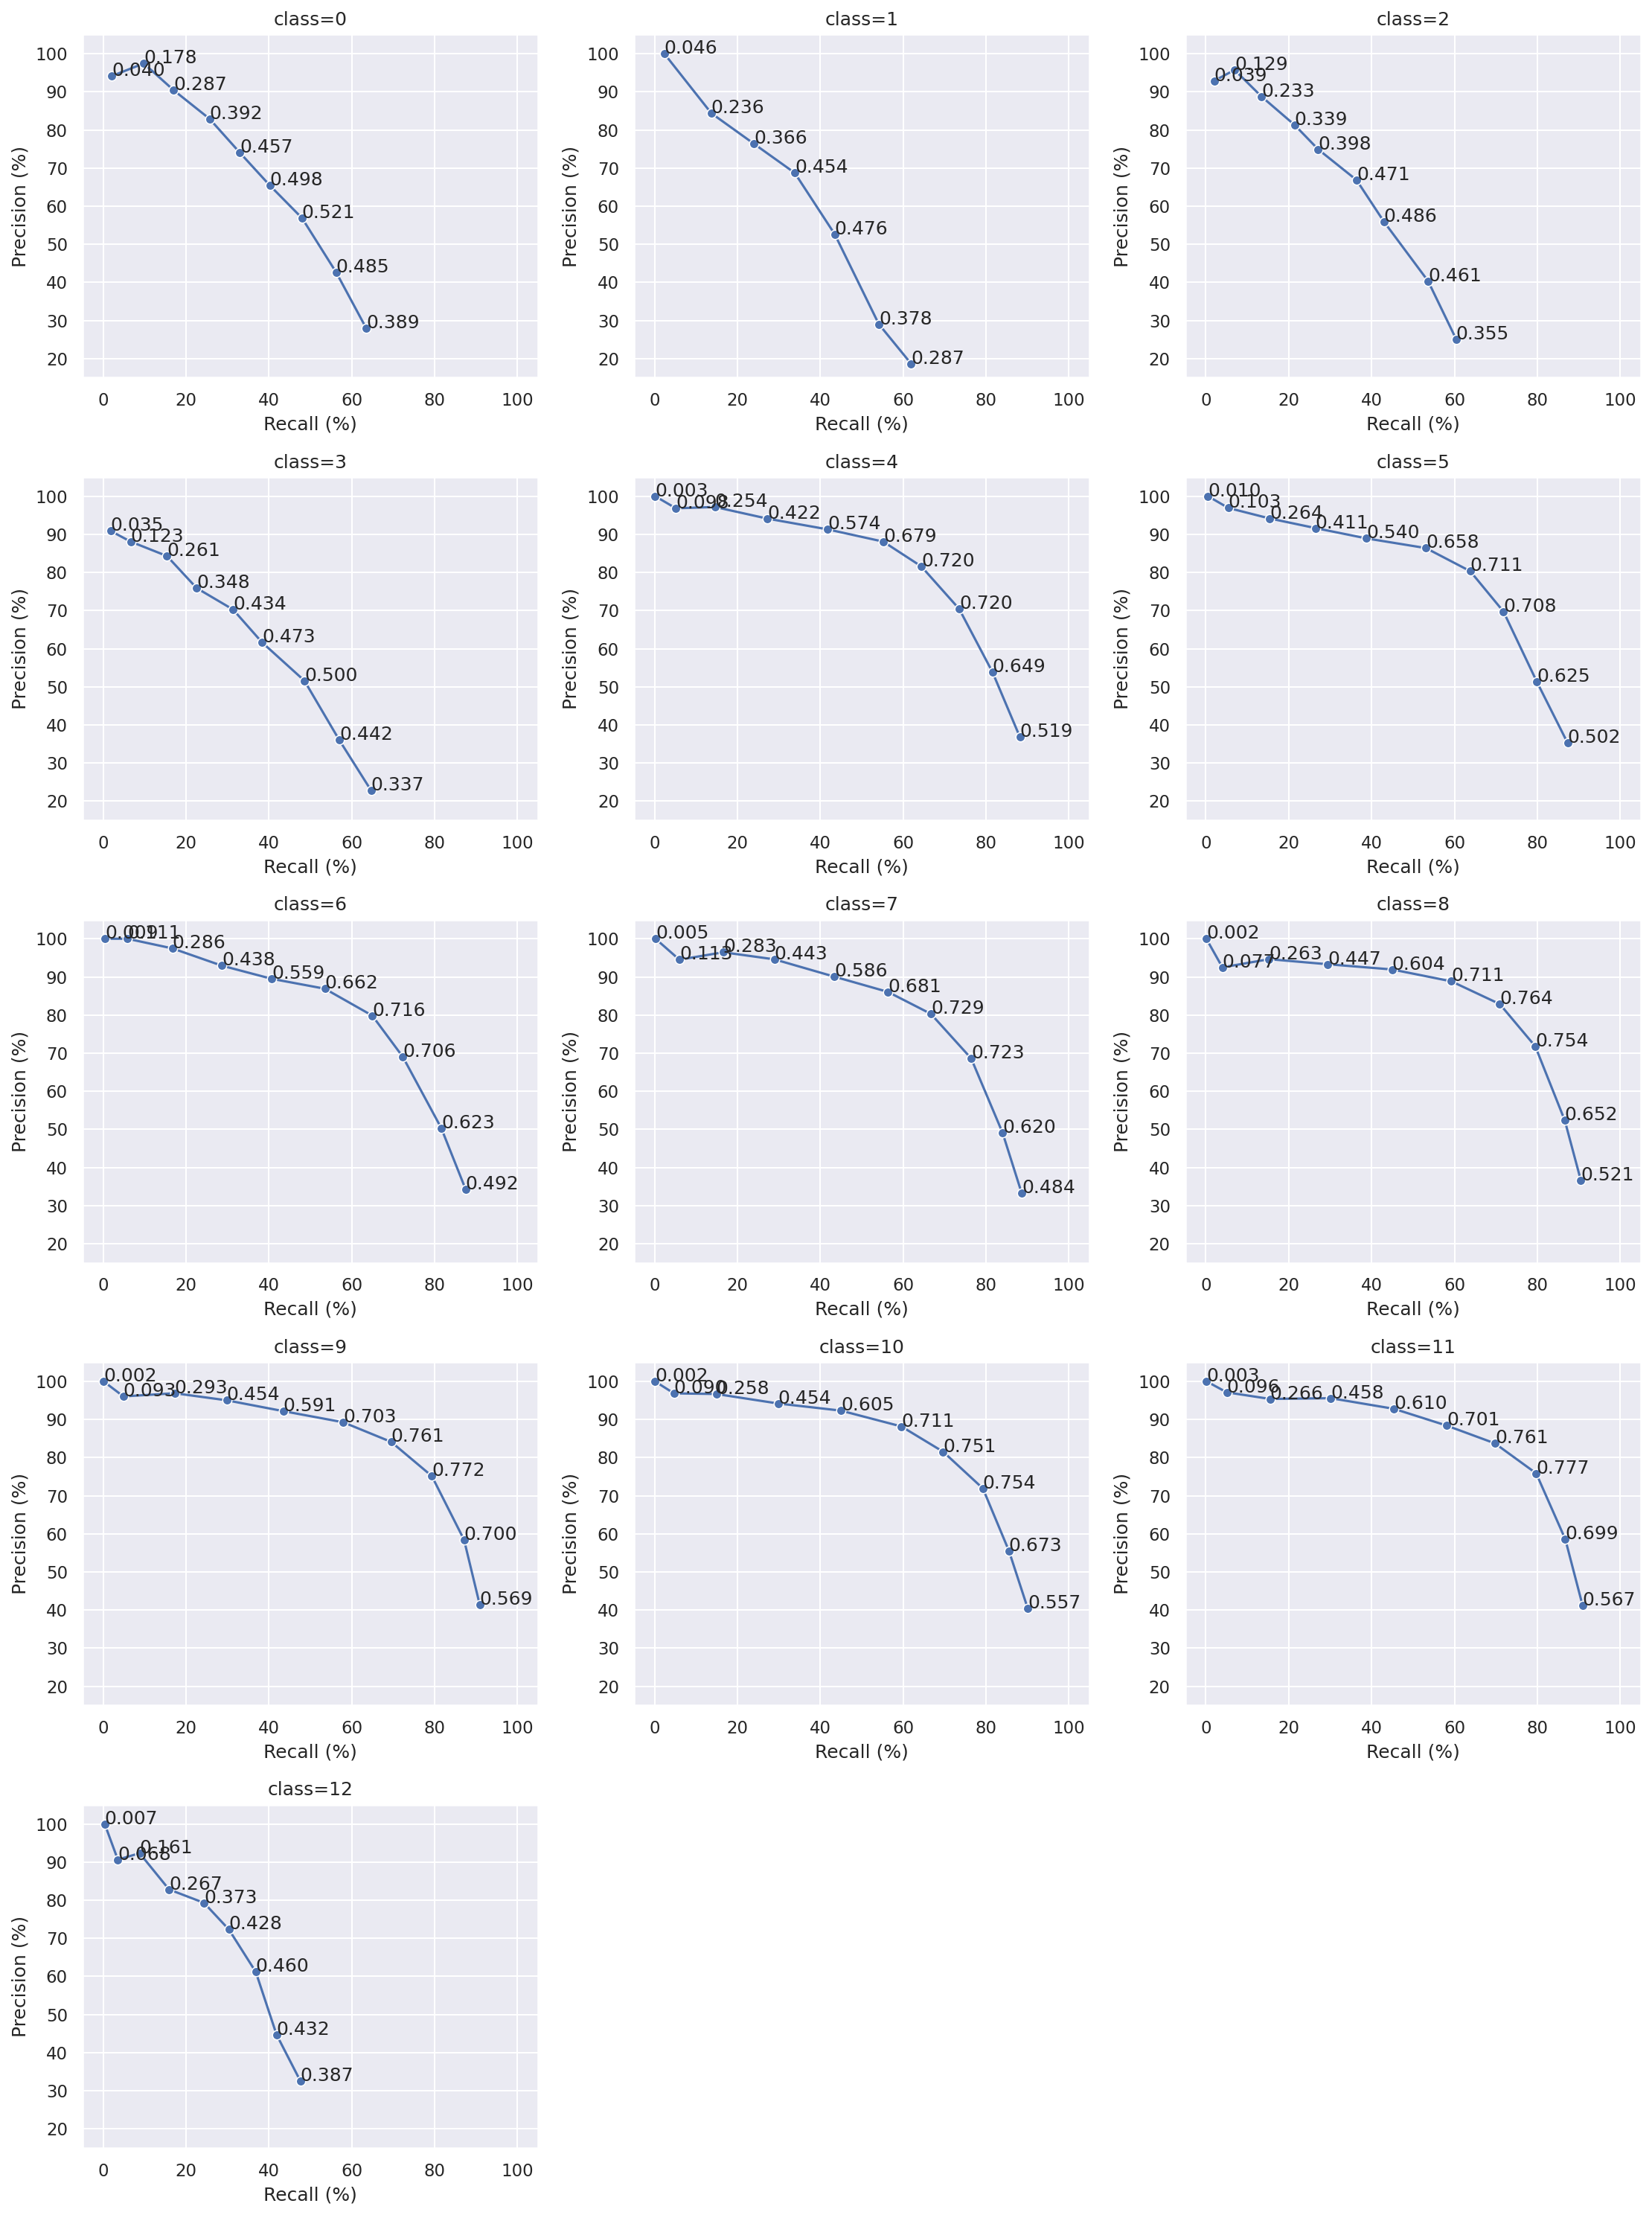

In [63]:
plot_per_class(junctions_by_class, x="Recall", y="Precision", by="class", figsize=(15, 20))

In [15]:
junctions_by_class[junctions_by_class["class"] == "5"]

,threshold,class,Recall,Precision
6,0,5,87.33,35.23
20,10,5,79.91,51.27
34,20,5,71.81,69.77
48,30,5,63.79,80.35
62,40,5,53.10,86.40
76,50,5,38.79,88.93
90,60,5,26.47,91.64
104,70,5,15.34,94.18
118,80,5,5.43,96.92
132,90,5,0.52,100.00


## Wall junctions (no class)

In [16]:
junctions_no_class = pd.read_csv(f"{RESULTS_DIR}/wall_junctions_no_class.csv")
# junctions_no_class.at[10, 'Precision'] = 100.00

junctions_no_class["F1-score"] = (2*(junctions_no_class["Precision"]/100)*(junctions_no_class["Recall"]/100))/(junctions_no_class["Precision"]/100+junctions_no_class["Recall"]/100)
junctions_no_class["class"] = "overall"
print(junctions_no_class)

    threshold  Recall  Precision  F1-score    class
0           0   86.10      50.19  0.634142  overall
1          10   82.29      63.35  0.715885  overall
2          20   75.17      78.35  0.767271  overall
3          30   65.35      86.78  0.745556  overall
4          40   53.83      91.59  0.678076  overall
5          50   40.15      94.50  0.563561  overall
6          60   26.06      96.40  0.410286  overall
7          70   13.83      97.72  0.242307  overall
8          80    4.27      97.41  0.081814  overall
9          90    0.16     100.00  0.003195  overall
10        100    0.00        NaN       NaN  overall


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


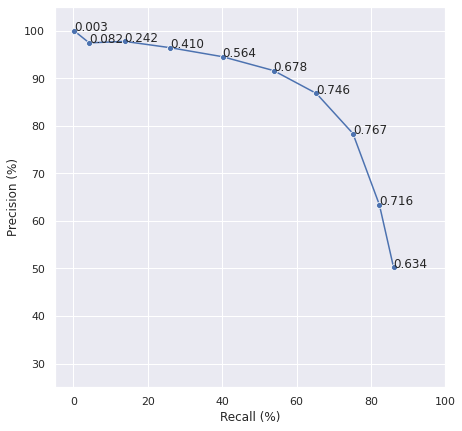

In [17]:
plt.figure(figsize=(7,7))
sns.lineplot(data=junctions_no_class, x="Recall", y="Precision", markers=True, style="class", legend=False)
plt.ylabel("Precision (%)")
plt.xlabel("Recall (%)")
# plt.title("Precision-Recall curve for Junctions (no class)")

for index, row in junctions_no_class.iterrows():
    # plt.text(row["Recall"], row["Precision"], f"t={row['threshold']}; {row['F1-score']:.3f}")
    plt.text(row["Recall"], row["Precision"], f"{row['F1-score']:.3f}")

plt.xlim(-5, 100)
plt.ylim(25, 105)
plt.savefig(RESULTS_DIR + '/precision-recall-no-class.eps')

## Mixed Junctions

In [24]:
def normalize(data):
    total_gt = data.sum()
    return data/total_gt


def confusion_matrix_by_threshold(data, figsize=(15, 15)):
    for threshold in data.threshold.unique():
        d = data[data.threshold == threshold].copy()
        d.drop(["threshold"], axis=1, inplace=True)

        # Sanity check
        # d = d.apply(normalize, axis=1)
        # d = d.apply(normalize)
        mask = np.zeros_like(d)
        mask[-1, -1] = 1

        plt.figure(figsize=figsize)
        plt.title(f"Threshold={threshold/100:.1f}")
        # sns.heatmap(d, cmap="Blues", vmin=0, vmax=1, annot=True, cbar=False, fmt=".1%", mask=mask, linewidth=.5)
        sns.heatmap(d, cmap="Blues", annot=True, cbar=False, fmt="", mask=mask, linewidth=.5)
        plt.ylabel("Grount Truth")
        plt.xlabel("Predicted")
        # plt.savefig(RESULTS_DIR + f'/confusion-mixed-t={threshold}.eps')
        plt.show()

/tmp/ipykernel_1186/4022727566.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  j = data[data.threshold == t][data['class'] != 'overall']
/tmp/ipykernel_1186/4022727566.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j["n"] = list(d)
/tmp/ipykernel_1186/4022727566.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  j = data[data.threshold == t][data['class'] != 'overall']
/tmp/ipykernel_1186/4022727566.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

,threshold,Recall,Precision,F1-score
0,0,83.502758,35.471475,0.497917
1,10,78.126861,51.130316,0.618094
2,20,70.331590,68.697516,0.695050
3,30,61.360178,78.923549,0.690424
4,40,51.030078,85.226113,0.638370
5,50,38.445867,89.324603,0.537552
6,60,25.347520,93.451836,0.398785
7,70,13.585719,NaN,NaN
8,80,4.226978,NaN,NaN
9,90,0.159425,NaN,NaN


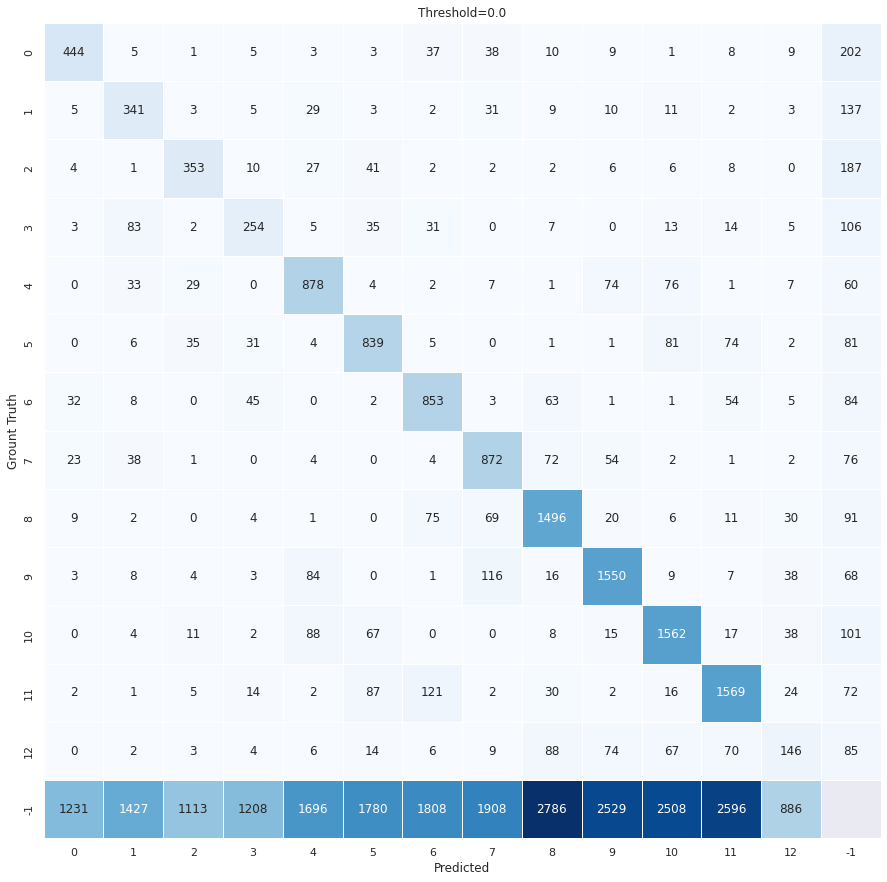

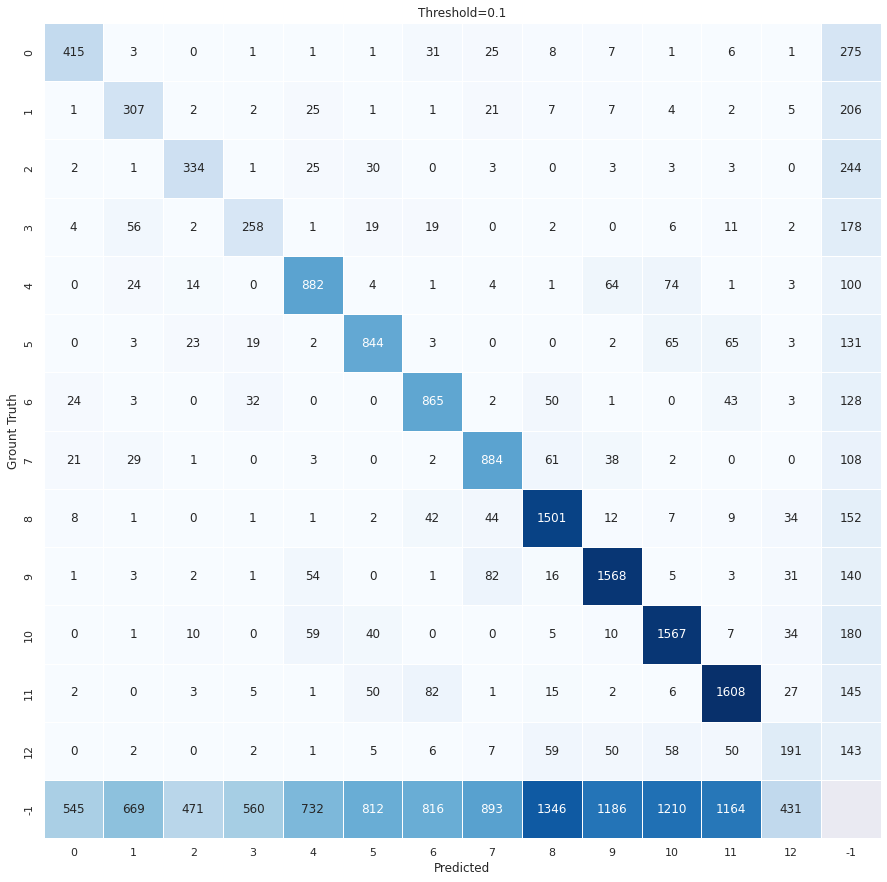

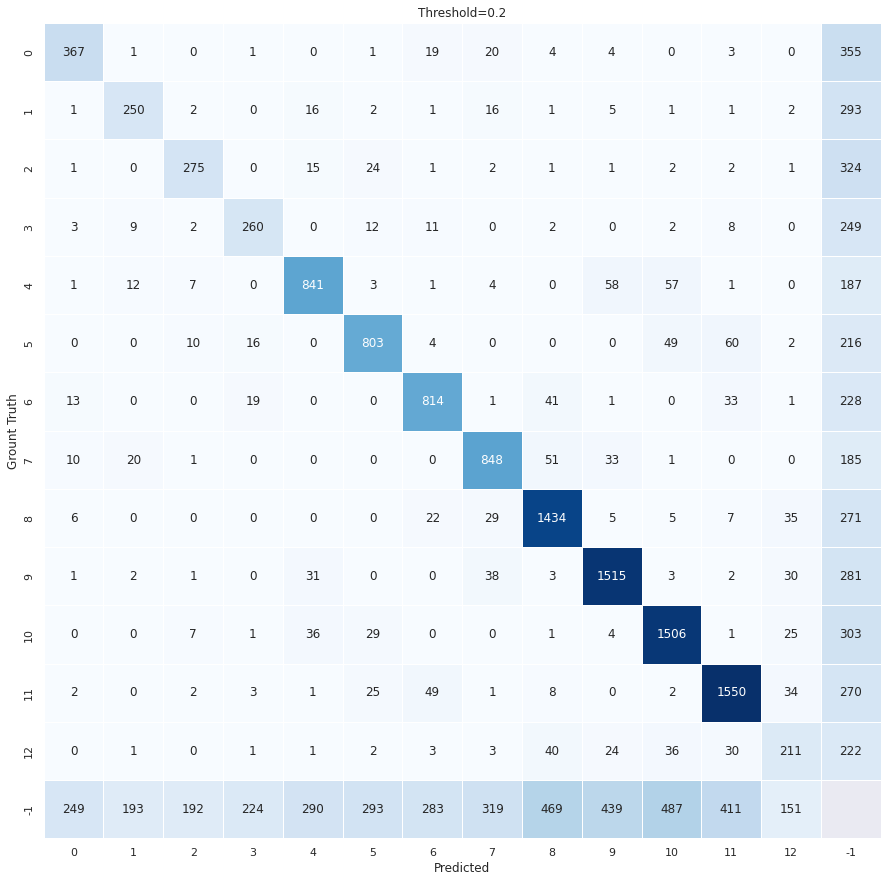

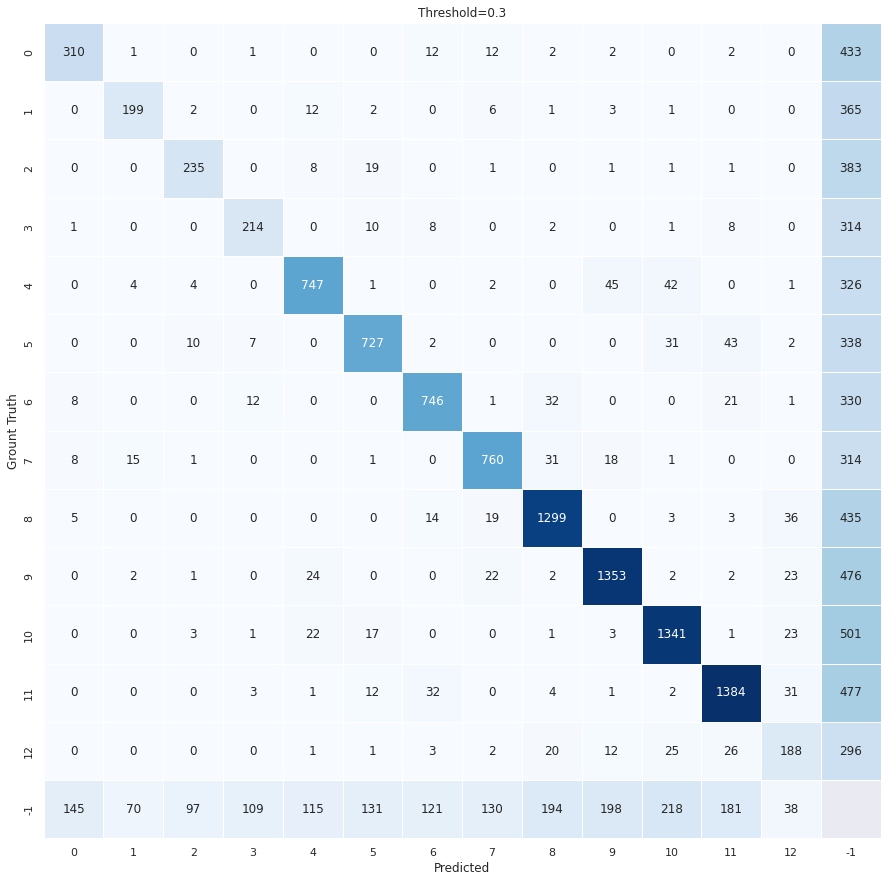

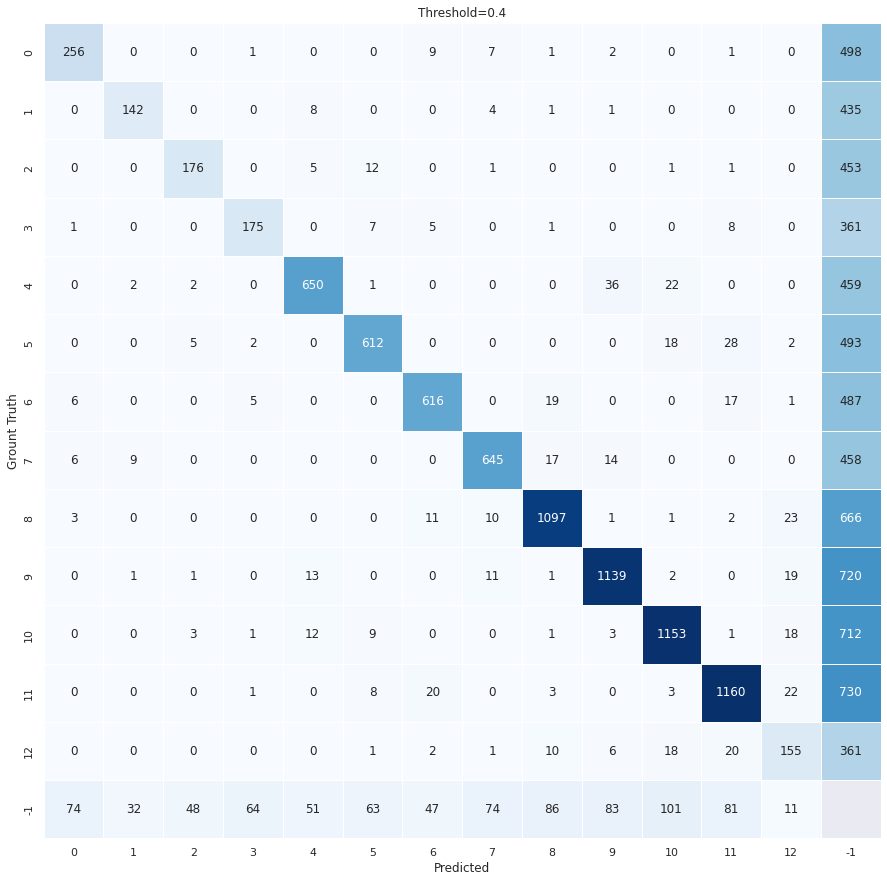

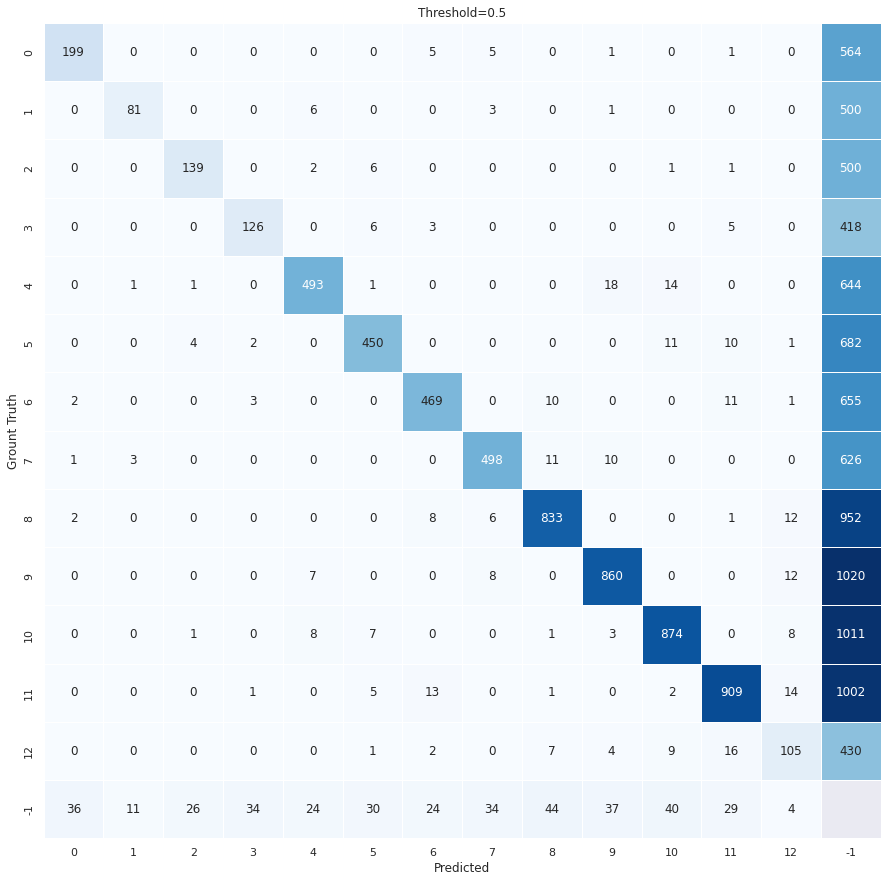

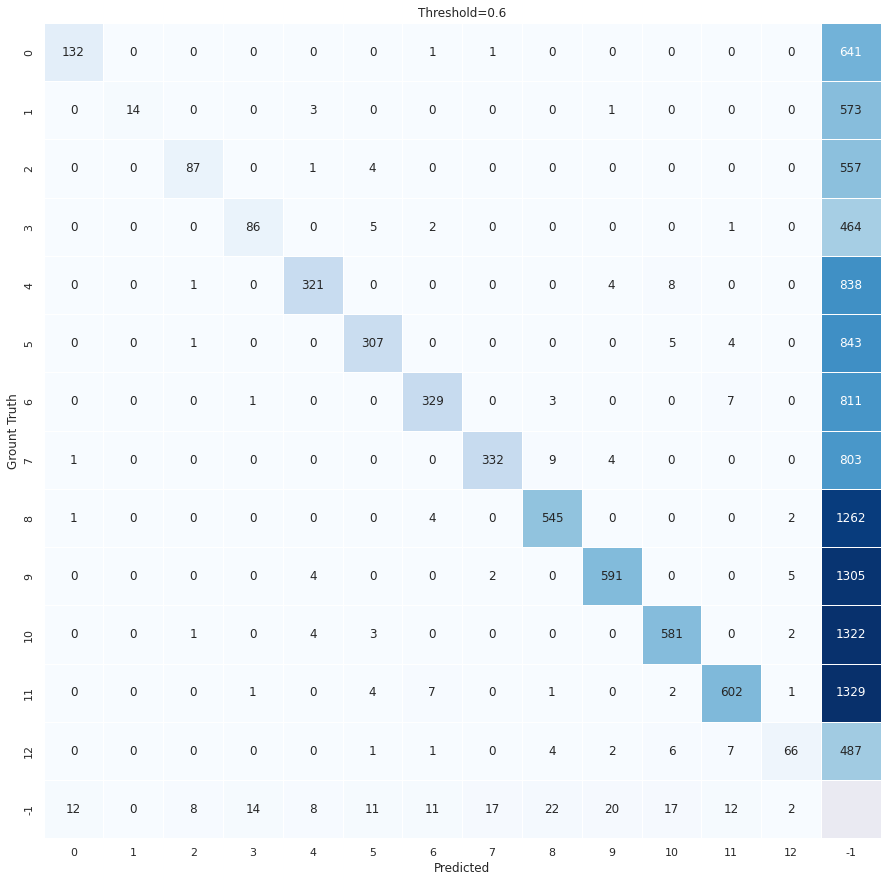

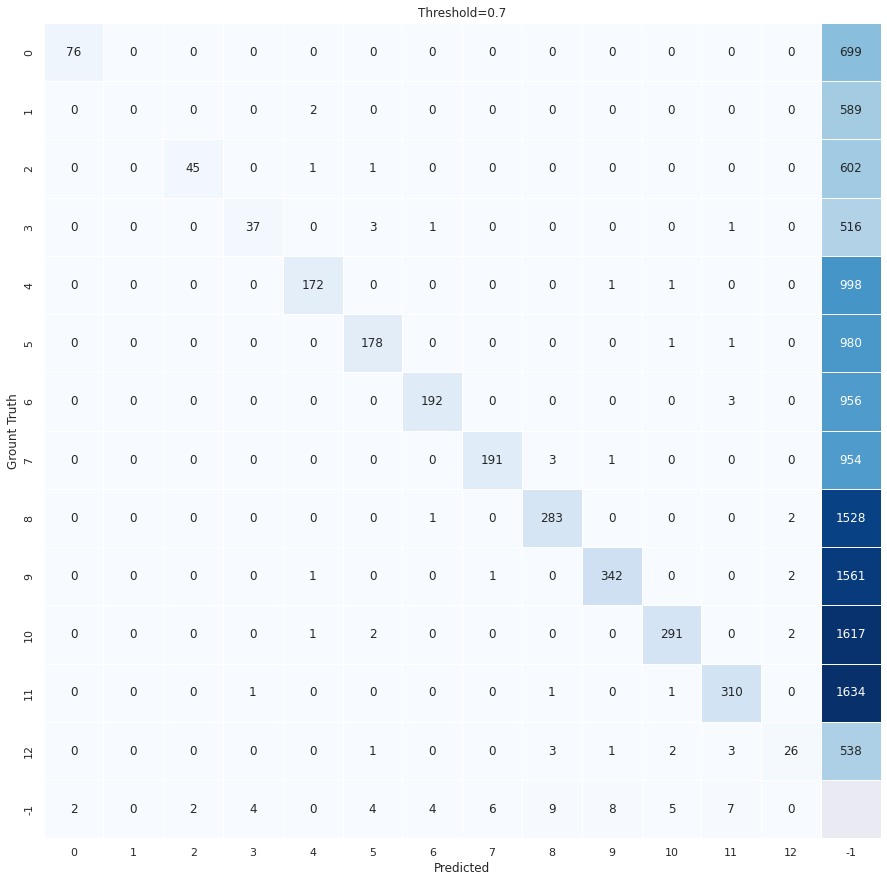

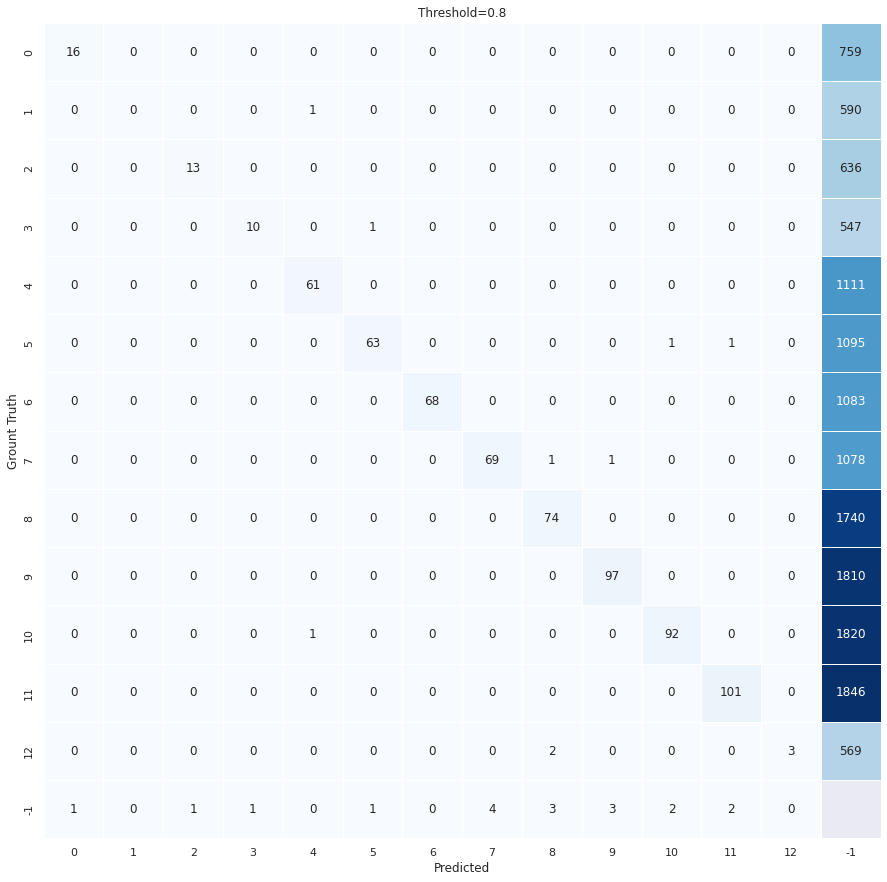

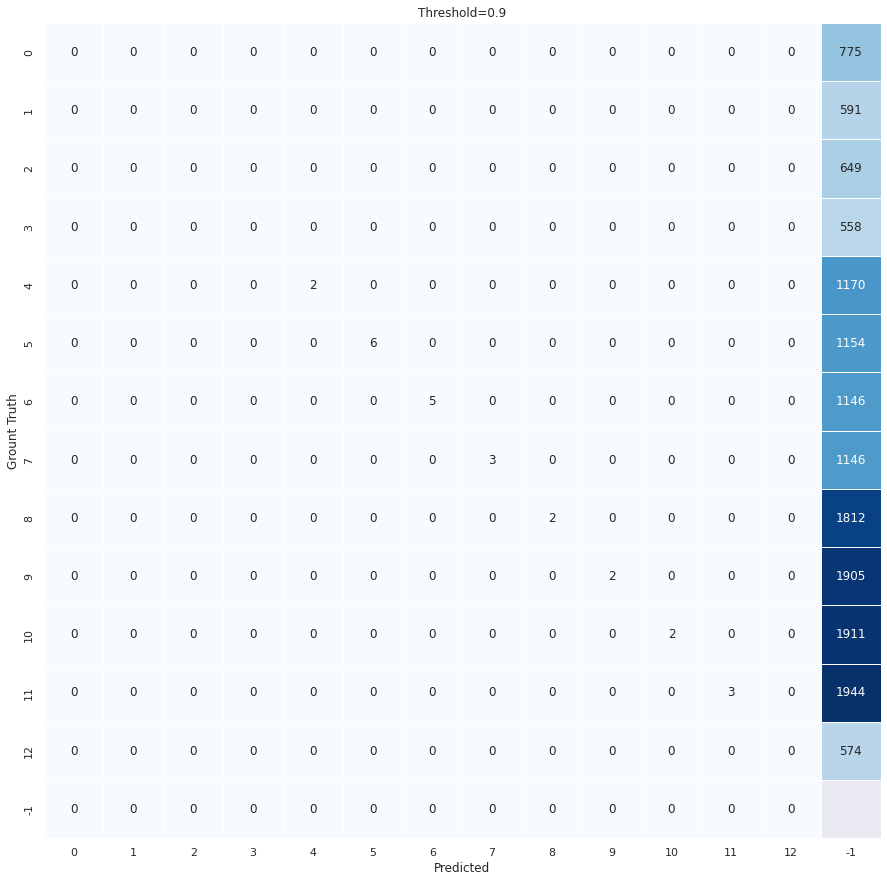

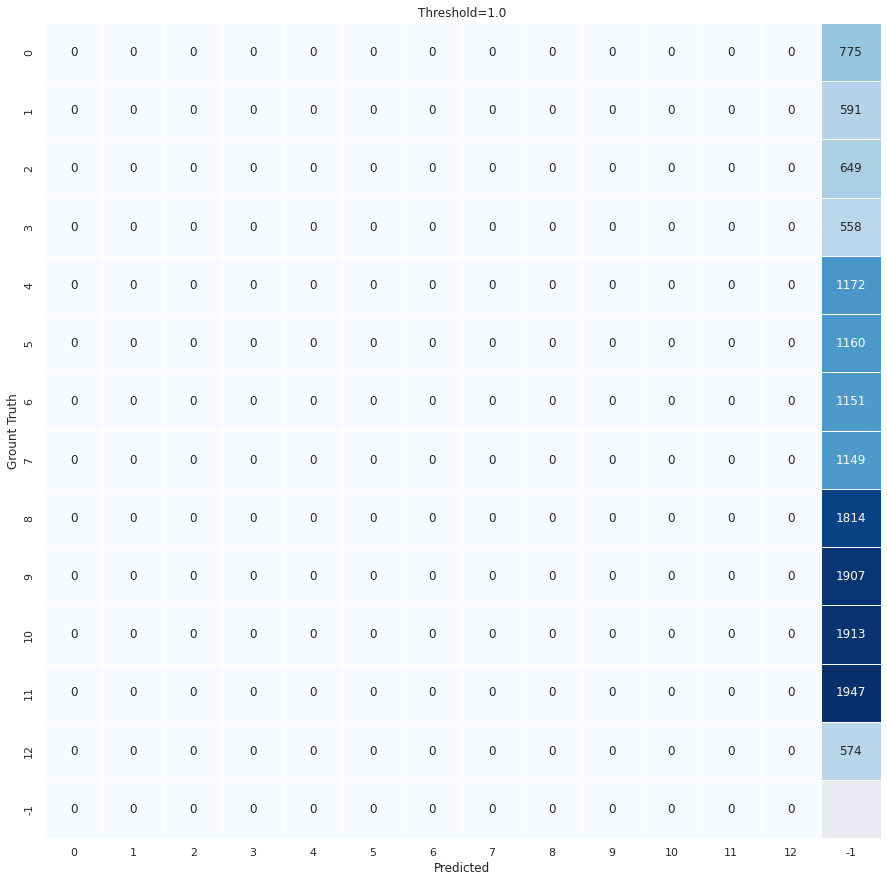

In [25]:
mixed_junctions = pd.read_csv(f"{RESULTS_DIR}/wall_junctions_mixed.csv").set_index("class")
confusion_matrix_by_threshold(mixed_junctions)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


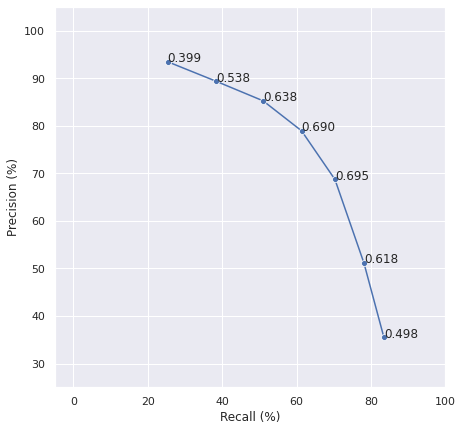

In [128]:
def per_class_weighted_average(data, mixed_junctions):
    res = []
    for t in sorted(data.threshold.unique()):

        d = mixed_junctions[mixed_junctions.threshold == t].copy()
        d = d.sum(axis=1)
        d = d.drop([-1])
        total = d.sum()

        j = data[(data.threshold == t) & (data['class'] != 'overall')]

        d = np.array(list(d))

        j = j.to_numpy()[:, 2:]
        recall = (j[:,0]*d).sum()/total
        precision = (j[:,1]*d).sum()/total

        res.append({'class': 'weighted', 'threshold': t, 'Recall': recall, 'Precision': precision})

    df = pd.DataFrame(res)
    df["F1-score"] = (2*(df["Precision"]/100)*(df["Recall"]/100))/(df["Precision"]/100+df["Recall"]/100)
    return df

per_class_weighted_avg = per_class_weighted_average(junctions, mixed_junctions)

plt.figure(figsize=(7,7))
g = sns.lineplot(data=per_class_weighted_avg, x="Recall", y="Precision", markers=True, style="class", legend=None)
plt.ylabel("Precision (%)")
plt.xlabel("Recall (%)")

for index, row in per_class_weighted_avg.iterrows():
    # plt.text(row["Recall"], row["Precision"], f"t={row['threshold]}; {row['F1-score']:.3f}")
    plt.text(row["Recall"], row["Precision"], f"{row['F1-score']:.3f}")

plt.xlim(-5, 100)
plt.ylim(25, 105)
plt.savefig(RESULTS_DIR + '/per-class-weighed-average-recall-overall.eps')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


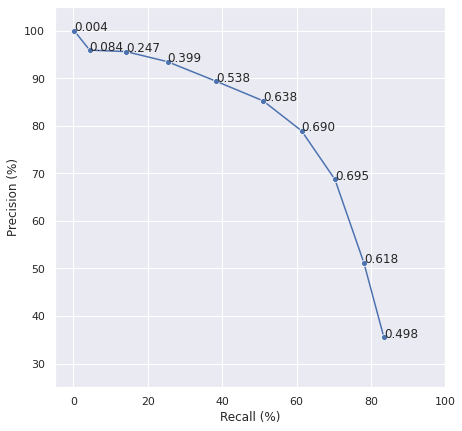

In [126]:
def per_class_weighted_average_nnan(data, mixed_junctions):
    res = []
    for t in sorted(data.threshold.unique()):
        d = mixed_junctions[mixed_junctions.threshold == t].copy()
        d = d.sum(axis=1)
        d = d.drop([-1])

        j = data[(data.threshold == t) & (data['class'] != 'overall')]

        precision = 0
        recall = 0
        total = 0

        for i, row in j.iterrows():
            if pd.isna(row.Recall) or pd.isna(row.Precision):
                continue

            c = int(row['class'])
            recall += row.Recall * d[c]
            precision += row.Precision * d[c]
            total += d[c]

        if total > 0:
            recall /= total
            precision /= total
        else:
            recall = precision = np.nan

        res.append({'class': 'weighted', 'threshold': t, 'Recall': recall, 'Precision': precision})

    df = pd.DataFrame(res)
    df["F1-score"] = (2*(df["Precision"]/100)*(df["Recall"]/100))/(df["Precision"]/100+df["Recall"]/100)
    return df


per_class_weighted_avg_nnan = per_class_weighted_average_nnan(junctions, mixed_junctions)

plt.figure(figsize=(7,7))
g = sns.lineplot(data=per_class_weighted_avg_nnan, x="Recall", y="Precision", markers=True, style="class", legend=None)
plt.ylabel("Precision (%)")
plt.xlabel("Recall (%)")

for index, row in per_class_weighted_avg_nnan.iterrows():
    plt.text(row["Recall"], row["Precision"], f"{row['F1-score']:.3f}")

plt.xlim(-5, 100)
plt.ylim(25, 105)
plt.savefig(RESULTS_DIR + '/per-class-weighed-nnan-average-recall-overall.eps')